# 언어 모델
## - koBERT , KoELECTRA , KcBERT , KcELECTRA

# 환경 설정 & KoBERT 설치
- https://github.com/ChangZero/koBERT-finetuning-demo/blob/main/kobert_colab.ipynb

In [1]:
# wandb 설치
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=a25666d7f540d7270ecc5c0c62229cd518df0822cda61bbc796a73c02a86cbb8
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
# # install and restart
# !pip install mxnet
# !pip install gluonnlp==0.8.0
# !pip install tqdm pandas
# !pip install sentencepiece
# !pip install transformers
# !pip install torch>=1.8.1
# !pip install transformers
# !pip install wandb # wandb 설치

# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [6]:
!pip install transformers


In [7]:
# import gluonnlp as nlp
# from transformers import BertModel
# from kobert_tokenizer import KoBERTTokenizer
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import datetime
import wandb
import time

In [8]:
# torch GPU 설정
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
device

device(type='cuda')

# git clone data

In [ ]:
!git clone https://github.com/huijunam/CJ_AI_hackathon.git

Cloning into 'CJ_AI_hackathon'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 160 (delta 39), reused 75 (delta 33), pack-reused 69
Receiving objects: 100% (160/160), 19.87 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [ ]:
import pandas as pd
df_data = pd.read_csv('/content/CJ_AI_hackathon/data/final_dataset.csv')

In [ ]:
df_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
90090,얘긴 다 끝났냐? 원예부,중립
90091,"예. 그거 때문에, 부탁이 있......는......데요.",중립
90092,여자 숨겨달라는거면 사절이다.,중립
90093,아무래도 안되나요?,중립


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90095 entries, 0 to 90094
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  90095 non-null  object
 1   Emotion   90095 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd


In [13]:
data1 = pd.read_excel('/content/drive/MyDrive/Prog_All/Data/감성대화말뭉치.xlsx')

data2 = pd.read_excel('/content/drive/MyDrive/Prog_All/Data/ko_단발성_대화_데이터셋.xlsx')
data3 = pd.read_excel('/content/drive/MyDrive/Prog_All/Data/ko_연속적_대화_데이터셋.xlsx')

data4 = pd.read_excel('/content/drive/MyDrive/Prog_All/Data/kaggle_hate_data4.xlsx')
data5 = pd.read_excel('/content/drive/MyDrive/Prog_All/Data/hf_hate_data5.xlsx')


In [14]:
data1.columns

Index(['Emotion', 'Sentence'], dtype='object')

In [15]:
data1 = data1[['Sentence','Emotion']]

In [16]:
data1

,Sentence,Emotion
0,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.,행복
1,요즘 직장생활이 너무 편하고 좋은 것 같아!,행복
2,취업해야 할 나이인데 취업하고 싶지가 않아.,행복
3,면접에서 부모님 직업에 대한 질문이 들어왔어.,공포
4,큰일이야. 부장님께 결재받아야 하는 서류가 사라졌어. 한 시간 뒤에 제출해야 하는데...,공포
...,...,...
70517,코로나 시국에 광화문 집회니 모여서 예배를 드리니 왜 그러는 거야? 다 잡아갔으면 ...,분노
70518,남자친구와 하루라도 더 같이 지내고 싶거든.,행복
70519,임신 기간 내내 몸이 좋지 않아 많이 불안했는데 다행히 건강하게 아기가 태어났어. ...,행복
70520,아이도 놀랐는데 살짝 넘어져서 그런지 크게 다친 건 없어서 다행이었어.,행복


In [17]:
data1['Emotion'].unique()

array(['행복', '공포', '놀람', '슬픔', '분노', '중립'], dtype=object)

In [18]:
data2 = data2[['Sentence','Emotion']]
data3 = data3[['Unnamed: 1','Unnamed: 2']]
data3.drop([0],axis=0,inplace=True)
data3.rename(columns={'Unnamed: 1':'Sentence','Unnamed: 2':'Emotion'},inplace=True)
data3.replace('ㅍ','공포',inplace=True)
data3.replace(['분','분ㄴ'],'분노',inplace=True)
data3.replace(['ㅈ중립','중림','ㄴ중립','줄'],'분노',inplace=True)

<ipython-input-18-0acbb591ece0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.drop([0],axis=0,inplace=True)
<ipython-input-18-0acbb591ece0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.rename(columns={'Unnamed: 1':'Sentence','Unnamed: 2':'Emotion'},inplace=True)
<ipython-input-18-0acbb591ece0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.replace('ㅍ','공포',inplace=True)


In [19]:
# nan 제거
data3 = data3.dropna(how='any')

In [20]:
print(data1['Emotion'].unique())
print(data2['Emotion'].unique())
print(data3['Emotion'].unique())
print(data4['Emotion'].unique()) #캐글 혐오 데이터
print(data5['Emotion'].unique()) # hf 혐오 데이터

['행복' '공포' '놀람' '슬픔' '분노' '중립']
['공포' '놀람' '분노' '슬픔' '중립' '행복' '혐오']
['분노' '혐오' '중립' '놀람' '행복' '공포' '슬픔']
['혐오']
['혐오']


In [21]:
data1['Emotion'].value_counts()

슬픔    26468
행복    13428
분노    12430
공포    12238
놀람     4006
중립     1952
Name: Emotion, dtype: int64

In [22]:
value_to_remove = '놀람'
data1 = data1[data1['Emotion'] != value_to_remove]

In [23]:
print(data1['Emotion'].value_counts())
print(data2['Emotion'].value_counts())
print(data3['Emotion'].value_counts())
print(data4['Emotion'].value_counts())
print(data5['Emotion'].value_counts())

슬픔    26468
행복    13428
분노    12430
공포    12238
중립     1952
Name: Emotion, dtype: int64
행복    6037
놀람    5898
분노    5665
공포    5468
혐오    5429
슬픔    5267
중립    4830
Name: Emotion, dtype: int64
중립    43786
놀람     4866
분노     3637
슬픔     1972
행복     1030
혐오      220
공포      110
Name: Emotion, dtype: int64
혐오    2033
Name: Emotion, dtype: int64
혐오    15005
Name: Emotion, dtype: int64


In [24]:
df_data = pd.concat([data1,data2,data3,data4,data5])
df_data.sample(n=10)

,Sentence,Emotion
32770,아버님은 좀 어떠시대요.,중립
4996,갑자기 양쪽 유두에서 모유가 막 나오네요..,공포
33519,공업용 미싱으로 입 꼬매줘,혐오
60029,나이들었다고 무시하는게 많은거같아.,분노
1397,코로나로 인해 비상 근무체제로 돌입하기로 했는데 팀장님이 나를 지목하셨어. 뭔가 희...,슬픔
41167,친구도 많고 성격도 좋아서 다른 사람들은 칭찬하는 아인데 그런 쪽으로 알아봐야 할까 봐.,행복
54409,딱히 출처는 없어.,중립
26919,부르셨다고..,중립
6577,여기 애들 부들부들 대단하다ㅋㅋㅋㅋ,놀람
29800,회사를 정년퇴직하고 나니까 아무도 찾아오는 사람도 없고 이제 돈도 떨어졌어.,슬픔


In [25]:
len(df_data)

177769

In [26]:
df_data['Emotion'].value_counts()

중립    50568
슬픔    33707
혐오    22687
분노    21732
행복    20495
공포    17816
놀람    10764
Name: Emotion, dtype: int64

In [27]:
df_data.drop_duplicates(['Sentence','Emotion'],inplace=True) # 중복행 제거
len(df_data)

172177

In [28]:
df_data['Emotion'].value_counts() # 단발성+연속성+감성대화말뭉치+캐글_혐오데이터+hf_혐오데이터

중립    47534
슬픔    33129
혐오    22658
분노    21400
행복    20017
공포    17573
놀람     9866
Name: Emotion, dtype: int64

In [29]:
# 추출할 특정 값을 지정
target_value = '놀람'
# 데이터프레임에서 특정 값을 가지는 행 추출
filtered_rows = df_data[df_data['Emotion'] == target_value]
# 추출된 행을 변수로 저장
selected_rows = filtered_rows.copy()
type(selected_rows)

pandas.core.frame.DataFrame

In [30]:
import random
# 추출할 특정 값

neut_val = '중립'
sad_val = '슬픔'
hate_val = '혐오'
ang_val = '분노'
happ_val = '행복'
fear_val = '공포'



# 특정 값을 가지는 행들을 필터링
neut_val_rows = df_data[df_data['Emotion'] == neut_val]
sad_val_rows = df_data[df_data['Emotion'] == sad_val]
hate_val_rows = df_data[df_data['Emotion'] == hate_val]
ang_val_rows = df_data[df_data['Emotion'] == ang_val]
happ_val_rows = df_data[df_data['Emotion'] == happ_val]
fear_val_rows = df_data[df_data['Emotion'] == fear_val ]


# 무작위로 100개 행을 추출
random_neut_val = random.sample(range(len(neut_val_rows)), 10000)
random_sad_val = random.sample(range(len(sad_val_rows)), 10000)
random_hate_val = random.sample(range(len(hate_val_rows)), 10000)
random_ang_val = random.sample(range(len(ang_val_rows)), 10000)
random_happ_val = random.sample(range(len(happ_val_rows)), 10000)
random_fear_val = random.sample(range(len(fear_val_rows)), 10000)


# 추출된 인덱스를 사용하여 행을 선택
neut_rows = neut_val_rows.iloc[random_neut_val]
sad_rows = sad_val_rows.iloc[random_sad_val]
hate_rows = hate_val_rows.iloc[random_hate_val]
ang_rows = ang_val_rows.iloc[random_ang_val]
happ_rows = happ_val_rows.iloc[random_happ_val]
fear_rows = fear_val_rows.iloc[random_fear_val]



In [31]:
data10000 = pd.concat([neut_rows,sad_rows,hate_rows,ang_rows,happ_rows,fear_rows])
data10000.sample(n=10)

,Sentence,Emotion
26930,장애가 생겨서 일하기도 힘든데 경제적으로도 어려워서 짜증 나.,공포
23529,로우지 맛있을거 같다,중립
29849,자랑스러운 한국인! 당신을 존경합니다.,행복
66190,이렇게 힘없는 내가 너무 싫어. 기분도 계속 우울하고.,분노
28027,내 가족과 함께 행복하게 살고 싶어. 하지만 가정생활을 통해 스트레스를 받아 슬퍼.,분노
382,안녕하세요~방제이탈인지 몰겠네요^^;;,공포
48665,내가 돈 떼먹는 사람도 아니고 바로 내일 줄 텐데 어쩜 이러지? 너무 실망이야.,슬픔
3848,솔직히 앞일은 모르는거라 갠히 불안해지고 ㅠㅠ..,공포
28264,캬 bbc까지 극찬을!!!!!,행복
12180,경로당 사람들이 내 만성질환에 대해 다 알고 있었어.,분노


In [32]:
data10000['Emotion'].value_counts() #만개씩

중립    10000
슬픔    10000
혐오    10000
분노    10000
행복    10000
공포    10000
Name: Emotion, dtype: int64

In [33]:
df_data = pd.concat([data10000,selected_rows])

In [34]:
df_data['Emotion'].value_counts() #만개씩

중립    10000
슬픔    10000
혐오    10000
분노    10000
행복    10000
공포    10000
놀람     9866
Name: Emotion, dtype: int64

# target classes

In [35]:
target_classes ={
    '공포': 0,
    '놀람': 1,
    '분노': 2,
    '슬픔': 3,
    '중립': 4,
    '행복': 5,
    '혐오': 6
  }

In [36]:
# 레이블링
for cls in target_classes:
  df_data.loc[(df_data['Emotion'] == cls), 'Emotion'] = target_classes[cls]

In [37]:
data_list =[]
# ['sentence', 'class'] 형태로 변환
for q, label in zip(df_data['Sentence'], df_data['Emotion']):
  data =[]
  data.append(q)
  data.append(str(label))

  data_list.append(data)

print(data_list[6000])

['우리 사이에 그러면 안되지. ', '4']


In [ ]:
# model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']

In [38]:
# 하이퍼 파라미터 설정
max_length = 100
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5
random_seed = 42

# wandb 설정

In [39]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [40]:
# wandb init function
def wandb_init(model,max_length=max_length,
               batch_size=batch_size,num_epochs=num_epochs,
               log_interval=log_interval,learning_rate=learning_rate,extra='',random_seed=random_seed):

  # config
  wandb.config ={
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "seed": random_seed
  }
  # project: 폴더 이름, entity: team_5g (팀), name: 기록명
  test_time = datetime.datetime.now()
  extra ='' # 원본 데이터 일 경우
  # extra ='drop_data_' # drop data 일 경우
  wandb.init(project="KoElectra_10000",name=f"{model}_epoch_{num_epochs}_{extra}batch_size_{batch_size}_learning_rate_{learning_rate}/{test_time}"
            ,notes=f"KoElectra_10000-epoch_{num_epochs}-batch_size_{batch_size}-random_seed{random_seed}-learning_rate_{learning_rate}", entity='team_5g')
  # loss 추적
  wandb.define_metric('train_loss', summary='min')
  wandb.define_metric('val_loss', summary='min')
  # accuracy score 추적
  wandb.define_metric('train_accuracy', summary='max')
  wandb.define_metric('val_accuracy', summary='max')


In [ ]:
# BERTSentenceTransform 수정
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length, vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a) # 수정한 부분
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# kobert 공식 git에 있는 get_kobert_model 선언
def get_kobert_model(model_path, ctx=device):
    tokenizer = KoBERTTokenizer.from_pretrained(model_path)
    bertmodel = BertModel.from_pretrained(model_path)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj, tokenizer

In [ ]:
bertmodel, vocab, tokenizer = get_kobert_model('skt/kobert-base-v1')
# tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
train_list, test_list = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = random_seed)

In [ ]:
data_train = BERTDataset(train_list, 0, 1, tokenizer, vocab, max_length, True, False)
data_test = BERTDataset(test_list, 0, 1, tokenizer, vocab, max_length, True, False)

In [ ]:
# data_train[0] # 토큰화와 패딩 확인

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 2)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = len(target_classes),   # 클래스 현재 7개
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel, dr_rate = 0.5).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# KoBERT 모델

In [ ]:
KoBERT_y_preds =[]
KoBERT_label_list =[]

# wandb_init
wandb_init(model='koBERT') # model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# watch model
wandb.watch(model)
for e in range(num_epochs):
  train_acc = 0.0
  test_acc = 0.0
  train_loss =0.0
  test_loss =0.0

  model.train() #train
  start_time = time.time() # time

  for batch_id, (token_ids, valid_length, segment_ids, labels) in enumerate(tqdm(train_dataloader)):
    optimizer.zero_grad()
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    labels = labels.long().to(device)

    y_pred = model(token_ids, valid_length, segment_ids)

    loss = loss_fn(y_pred, labels)
    loss.backward()
    # 에포크 전체 손실을 누적합니다.
    train_loss += loss.item()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()  # Update learning rate schedule
    train_acc += calc_accuracy(y_pred, labels)

    if batch_id % log_interval == 0:
      print("epoch {} batch id {} loss {:.4f} train acc {:.4f}".format(e+1,batch_id+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))
    # wandb log
    wandb.log({"train_acc": train_acc/len(train_dataloader)}, commit=False)
    wandb.log({"train_loss": train_loss/len(train_dataloader)}, commit=False)

  print("epoch {} train acc {:.4f}".format(e+1, train_acc / len(train_dataloader)))

  model.eval() # inference
  for batch_id, (token_ids, valid_length, segment_ids, labels) in enumerate(tqdm(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    labels = labels.long().to(device)
    test_pred = model(token_ids, valid_length, segment_ids)

    KoBERT_y_preds.extend(test_pred.cpu().detach().numpy()) # for confusion matrix
    KoBERT_label_list.extend(labels.cpu().numpy()) # for confusion matrix true label

    loss = loss_fn(test_pred, labels)
    loss.backward()
    test_loss += loss.item()
    test_acc += calc_accuracy(test_pred, labels)

    # wandb log
    wandb.log({"val_acc": test_acc/len(test_dataloader)}, commit=False)
    wandb.log({"val_loss": test_loss/len(test_dataloader)})

  end_time = time.time()
  print("epoch {} test acc {:.4f}".format(e+1, test_acc / len(test_dataloader)))
  print("Time: {:.4f}sec".format((end_time - start_time)))

KoBERT_label_list = np.array(KoBERT_label_list)
KoBERT_y_preds = np.array(KoBERT_y_preds)

In [ ]:
# torch.save(model.state_dict(), "./base_model_koBERT_epoch3_.pt")

## Dataset

In [41]:
# Define a custom dataset class
class custom_dataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding = self.tokenizer(text,padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
    input_ids = encoding['input_ids'].squeeze() #
    attention_mask = encoding['attention_mask'].squeeze() #

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        # 'label': label
        # 'labels': torch.tensor(int(label), dtype=torch.float)
        'labels': torch.tensor(int(label), dtype=torch.long)
    }

In [42]:
train_list, test_list = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = random_seed)
train_list = pd.DataFrame(train_list, columns=['Sentence', 'Emotion'])
test_list = pd.DataFrame(test_list, columns=['Sentence', 'Emotion'])

# Load your training data
X_train = train_list['Sentence']
Y_train = train_list['Emotion']

# Load your testing data
X_test = test_list['Sentence']
Y_test = test_list['Emotion']

## train and validate function

In [43]:
def train_and_validate(model='default',model_name='default',train_data_loader='default', test_data_loader='default'):
  confusion_y_preds =[] # confusion matrix
  confusion_label_list =[] # confusion matrix
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  # wandb_init
  wandb_init(model=model_name) # model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
  # watch model
  wandb.watch(model)

  for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss =0.0
    test_loss =0.0

    start_time = time.time() # time

    model.train() #train
    for batch_id, batch in enumerate(tqdm(train_data_loader)):
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      labels = batch['labels']

      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)

      # 그래디언트 초기화
      optimizer.zero_grad()
      # 모델에 입력을 주어 예측을 생성합니다.
      outputs = model(input_ids, attention_mask=attention_mask)
      # 모델 출력에서 로짓(분류에 대한 점수)을 얻습니다.
      # 모델 예측
      logits = outputs.logits  # 최신 Transformers 라이브러리에서는 이렇게 사용할 수 있을 수 있음
      # 손실을 계산합니다.
      loss = criterion(logits, labels)
      # 역전파를 통해 그래디언트 계산
      loss.backward()
      # 에포크 전체 손실을 누적합니다.
      train_loss += loss.item()
      # 옵티마이저를 사용해 가중치를 업데이트
      optimizer.step()
      # 정확도
      # train_acc += calc_accuracy(np.argmax(logits.cpu().detach().numpy()), label)
      train_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))

      if batch_id % log_interval == 0:
        print("epoch {} batch id {} train loss {:.4f} train acc {:.4f}".format(e+1, batch_id+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

      # wandb log
      wandb.log({"train_acc": train_acc/(batch_id+1)}, commit=False)
      wandb.log({"train_loss": train_loss/(batch_id+1)}, commit=False)

    print("epoch {} train loss {:.4f} train acc {:.4f}".format(e+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

    # 모델 평가
    model.eval()
    with torch.no_grad():
      for batch_id, batch in enumerate(test_data_loader):
        # Validation 데이터 가져오기
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # 모델 예측
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        confusion_y_preds.extend(logits.argmax(dim=1).cpu().numpy()) # for confusion matrix
        confusion_label_list.extend(labels.cpu().numpy()) # for confusion matrix true label

        # 손실 계산
        loss = criterion(logits,labels)
        test_loss += loss.item()

        # 정확도 계산
        test_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))
        if batch_id % log_interval == 0:
          print("epoch {} batch id {} test loss {:.4f} test acc {:.4f}".format(e+1, batch_id+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))

      # wandb log
      wandb.log({"val_acc": test_acc/len(test_data_loader)},commit=False)
      wandb.log({"val_loss": test_loss/len(test_data_loader)})
      end_time = time.time()
      print("epoch {} test loss {:.4f} test acc {:.4f}".format(e+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))
      print("Time: {:.4f}sec".format((end_time - start_time)))

  return np.array(confusion_label_list), np.array(confusion_y_preds)

In [49]:
def show_confusion_matrix(label_list, y_preds, model_name='default'):
  cm = confusion_matrix(label_list, y_preds)
  # Define class labels (assuming 7 classes in this example)
  class_labels = list(dict(map(reversed, target_classes.items())).keys()) # true label

  plt.figure(figsize=(8, 6))
  fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True,
  show_absolute=False, show_normed=True, class_names=class_labels)

# 이미지를 드라이브에 저장
  image_path = f'/content/drive/MyDrive/Prog_All/{model_name}_10000_confusion_matrix.png'
  plt.savefig(image_path, bbox_inches="tight")


  plt.title(model_name)
  plt.show()

# KcBERT 모델
https://github.com/Beomi/KcBERT

In [ ]:
# KcBERT 모델과 토크나이저 로드
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

KcBERT_y_preds =[] # confusion matrix
KcBERT_label_list =[] # confusion matrix

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels =len(target_classes))
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# dataset
train_dataset = custom_dataset(X_train, Y_train, tokenizer, max_length)
test_dataset = custom_dataset(X_test, Y_test, tokenizer, max_length)

# dataloader
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
# model_name =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# wandb: 가 안뜨면 런타임 다시 시작 또는 삭제하고 !wandb login '본인 API 키' 다시 실행하고 돌려볼 것
model_name = 'KcBERT'
KcBERT_label_list, KcBERT_y_preds= train_and_validate(model=model,model_name=model_name,
                                                      train_data_loader=train_data_loader,test_data_loader=test_data_loader)

wandb: Currently logged in as: huijunam (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230918_150628-f2qbh8zx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run KcBERT_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-18 15:06:27.443158
wandb: ⭐️ View project at https://wandb.ai/team_5g/KoBERT
wandb: 🚀 View run at https://wandb.ai/team_5g/KoBERT/runs/f2qbh8zx


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 2.0109 train acc 0.1094
epoch 1 batch id 201 train loss 1.0721 train acc 0.6263
epoch 1 batch id 401 train loss 1.0106 train acc 0.6416
epoch 1 batch id 601 train loss 0.9825 train acc 0.6497
epoch 1 batch id 801 train loss 0.9665 train acc 0.6543
epoch 1 batch id 1001 train loss 0.9539 train acc 0.6591
epoch 1 train loss 0.9472 train acc 0.6615
epoch 1 batch id 1 test loss 0.9185 test acc 0.6719
epoch 1 batch id 201 test loss 0.8745 test acc 0.6843
epoch 1 test loss 0.8757 test acc 0.6855
Time: 1200.2323sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 2 batch id 1 train loss 0.8243 train acc 0.7188
epoch 2 batch id 201 train loss 0.7241 train acc 0.7408
epoch 2 batch id 401 train loss 0.7243 train acc 0.7400
epoch 2 batch id 601 train loss 0.7241 train acc 0.7391


In [ ]:
show_confusion_matrix(KcBERT_label_list,KcBERT_y_preds,model_name=model_name) # confusion matrix

# KcELECTRA 모델
https://github.com/Beomi/KcELECTRA

In [ ]:
# KcELECTRA 모델과 토크나이저 로드
model_name = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)
KcELECTRA_y_preds =[] # confusion matrix
KcELECTRA_label_list =[] # confusion matrix

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels =len(target_classes))
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
# dataset
train_dataset = custom_dataset(X_train, Y_train, tokenizer, max_length)
test_dataset = custom_dataset(X_test, Y_test, tokenizer, max_length)

# dataloader
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
# model_name =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# wandb: 가 안뜨면 런타임 다시 시작 또는 삭제하고 !wandb login '본인 API 키' 다시 실행하고 돌려볼 것
model_name = 'KcELECTRA'
KcELECTRA_label_list, KcELECTRA_y_preds = train_and_validate(model=model,model_name=model_name,
                                                      train_data_loader=train_data_loader,test_data_loader=test_data_loader)

wandb: Currently logged in as: huijunam (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230918_103837-ytla0tvv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run KcELECTRA_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-18 10:38:35.001419
wandb: ⭐️ View project at https://wandb.ai/team_5g/KoBERT
wandb: 🚀 View run at https://wandb.ai/team_5g/KoBERT/runs/ytla0tvv


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 1.9284 train acc 0.1719
epoch 1 batch id 201 train loss 1.1824 train acc 0.5981
epoch 1 batch id 401 train loss 1.0394 train acc 0.6388
epoch 1 batch id 601 train loss 0.9801 train acc 0.6572
epoch 1 batch id 801 train loss 0.9470 train acc 0.6667
epoch 1 batch id 1001 train loss 0.9240 train acc 0.6741
epoch 1 train loss 0.9130 train acc 0.6773
epoch 1 batch id 1 test loss 0.8837 test acc 0.7031
epoch 1 batch id 201 test loss 0.8068 test acc 0.7056
epoch 1 test loss 0.8082 test acc 0.7049
Time: 1204.4635sec


In [ ]:
show_confusion_matrix(KcELECTRA_label_list,KcELECTRA_y_preds,model_name) # confusion matrix

# KoELECTRA 모델
https://github.com/monologg/KoELECTRA

In [45]:
# Load the pre-trained LLM model and tokenizer
model_name = "monologg/koelectra-small-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels =len(target_classes))
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [46]:
# dataset
train_dataset = custom_dataset(X_train, Y_train, tokenizer, max_length)
test_dataset = custom_dataset(X_test, Y_test, tokenizer, max_length)

# dataloader
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [47]:
KoELECTRA_y_preds =[] # confusion matrix
KoELECTRA_label_list =[] # confusion matrix

In [48]:
# model_name =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# wandb: 가 안뜨면 런타임 다시 시작 또는 삭제하고 !wandb login '본인 API 키' 다시 실행하고 돌려볼 것
model_name = 'KoELECTRA'
KoELECTRA_label_list, KoELECTRA_y_preds= train_and_validate(model=model,model_name=model_name,
                                                      train_data_loader=train_data_loader,test_data_loader=test_data_loader)

wandb: Currently logged in as: tracy110410 (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230919_075149-jqwznfqh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run KoELECTRA_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-19 07:51:48.048487
wandb: ⭐️ View project at https://wandb.ai/team_5g/KoElectra_10000
wandb: 🚀 View run at https://wandb.ai/team_5g/KoElectra_10000/runs/jqwznfqh


  0%|          | 0/874 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 1.9395 train acc 0.1719
epoch 1 batch id 201 train loss 1.7251 train acc 0.3438
epoch 1 batch id 401 train loss 1.5619 train acc 0.4107
epoch 1 batch id 601 train loss 1.4538 train acc 0.4532
epoch 1 batch id 801 train loss 1.3817 train acc 0.4821
epoch 1 train loss 1.3607 train acc 0.4911
epoch 1 batch id 1 test loss 1.1461 test acc 0.5781
epoch 1 batch id 201 test loss 1.1249 test acc 0.5849
epoch 1 test loss 1.1268 test acc 0.5836
Time: 158.0714sec


  0%|          | 0/874 [00:00<?, ?it/s]

epoch 2 batch id 1 train loss 1.3494 train acc 0.4688
epoch 2 batch id 201 train loss 1.0553 train acc 0.6218
epoch 2 batch id 401 train loss 1.0462 train acc 0.6197
epoch 2 batch id 601 train loss 1.0425 train acc 0.6204
epoch 2 batch id 801 train loss 1.0397 train acc 0.6213
epoch 2 train loss 1.0379 train acc 0.6220
epoch 2 batch id 1 test loss 1.0544 test acc 0.5938
epoch 2 batch id 201 test loss 1.0336 test acc 0.6286
epoch 2 test loss 1.0355 test acc 0.6261
Time: 160.0018sec


  0%|          | 0/874 [00:00<?, ?it/s]

epoch 3 batch id 1 train loss 0.8694 train acc 0.7344
epoch 3 batch id 201 train loss 0.9479 train acc 0.6541
epoch 3 batch id 401 train loss 0.9405 train acc 0.6595
epoch 3 batch id 601 train loss 0.9420 train acc 0.6578
epoch 3 batch id 801 train loss 0.9385 train acc 0.6588
epoch 3 train loss 0.9383 train acc 0.6592
epoch 3 batch id 1 test loss 0.9461 test acc 0.6406
epoch 3 batch id 201 test loss 1.0311 test acc 0.6314
epoch 3 test loss 1.0360 test acc 0.6297
Time: 159.7927sec


  0%|          | 0/874 [00:00<?, ?it/s]

epoch 4 batch id 1 train loss 0.7264 train acc 0.7344
epoch 4 batch id 201 train loss 0.8606 train acc 0.6900
epoch 4 batch id 401 train loss 0.8632 train acc 0.6887
epoch 4 batch id 601 train loss 0.8676 train acc 0.6850
epoch 4 batch id 801 train loss 0.8665 train acc 0.6853
epoch 4 train loss 0.8684 train acc 0.6845
epoch 4 batch id 1 test loss 0.9638 test acc 0.6250
epoch 4 batch id 201 test loss 1.0068 test acc 0.6377
epoch 4 test loss 1.0106 test acc 0.6375
Time: 171.6792sec


  0%|          | 0/874 [00:00<?, ?it/s]

epoch 5 batch id 1 train loss 0.7901 train acc 0.7188
epoch 5 batch id 201 train loss 0.7888 train acc 0.7165
epoch 5 batch id 401 train loss 0.7916 train acc 0.7149
epoch 5 batch id 601 train loss 0.7981 train acc 0.7118
epoch 5 batch id 801 train loss 0.8021 train acc 0.7101
epoch 5 train loss 0.8047 train acc 0.7094
epoch 5 batch id 1 test loss 0.9394 test acc 0.6094
epoch 5 batch id 201 test loss 0.9991 test acc 0.6427
epoch 5 test loss 0.9975 test acc 0.6427
Time: 168.1993sec


<Figure size 800x600 with 0 Axes>

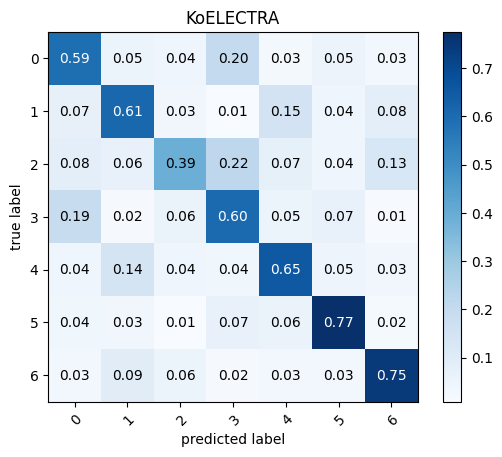

In [50]:
show_confusion_matrix(KoELECTRA_label_list,KoELECTRA_y_preds,model_name) # confusion matrix

In [53]:
from sklearn.metrics import f1_score
f1 = f1_score(KoELECTRA_label_list, KoELECTRA_y_preds , average='weighted')
# 결과 출력
print(f"F1-score: {f1:.4f}")

F1-score: 0.6201


In [ ]:
# # wandb_init
# wandb_init(model='KoELECTRA') # model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']

# # watch model
# wandb.watch(model)
# for e in range(num_epochs):
#   train_acc = 0.0
#   test_acc = 0.0
#   train_loss =0.0
#   test_loss =0.0

#   start_time = time.time() # time

#   model.train() #train
#   for batch_id, batch in enumerate(tqdm(train_data_loader)):
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']
#     labels = batch['labels']

#     input_ids = input_ids.to(device)
#     attention_mask = attention_mask.to(device)
#     labels = labels.to(device)

#     # 그래디언트 초기화
#     optimizer.zero_grad()
#     # 모델에 입력을 주어 예측을 생성합니다.
#     outputs = model(input_ids, attention_mask=attention_mask)
#     # 모델 출력에서 로짓(분류에 대한 점수)을 얻습니다.
#     # 모델 예측
#     logits = outputs.logits  # 최신 Transformers 라이브러리에서는 이렇게 사용할 수 있을 수 있음
#     # 손실을 계산합니다.
#     loss = criterion(logits, labels)
#     # 역전파를 통해 그래디언트 계산
#     loss.backward()
#     # 에포크 전체 손실을 누적합니다.
#     train_loss += loss.item()
#     # 옵티마이저를 사용해 가중치를 업데이트
#     optimizer.step()
#     # 정확도
#     # train_acc += calc_accuracy(np.argmax(logits.cpu().detach().numpy()), label)
#     train_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))

#     if batch_id % log_interval == 0:
#       print("epoch {} batch id {} train loss {:.4f} train acc {:.4f}".format(e+1, batch_id+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

#     # wandb log
#     wandb.log({"train_acc": train_acc/(batch_id+1)}, commit=False)
#     wandb.log({"train_loss": train_loss/(batch_id+1)}, commit=False)
#   # # # wandb log
#   # wandb.log({"train_acc": train_acc/len(train_data_loader)}, commit=False)
#   # wandb.log({"train_loss": train_loss/len(train_data_loader)},commit=False)

#   print("epoch {} train loss {:.4f} train acc {:.4f}".format(e+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

#   # 모델 평가
#   model.eval()
#   with torch.no_grad():
#     for batch_id, batch in enumerate(test_data_loader):
#       # Validation 데이터 가져오기
#       input_ids = batch['input_ids']
#       attention_mask = batch['attention_mask']
#       labels = batch['labels']

#       input_ids = input_ids.to(device)
#       attention_mask = attention_mask.to(device)
#       labels = labels.to(device)

#       # 모델 예측
#       outputs = model(input_ids, attention_mask=attention_mask)
#       logits = outputs.logits

#       KoELECTRA_y_preds.extend(logits.argmax(dim=1).cpu().numpy()) # for confusion matrix
#       KoELECTRA_label_list.extend(labels.cpu().numpy()) # for confusion matrix true label

#       # 손실 계산
#       loss = criterion(logits,labels)
#       test_loss += loss.item()

#       # 정확도 계산
#       # preds = logits.argmax(dim=1)
#       # test_acc += calc_accuracy(np.argmax(logits), label)
#       test_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))
#       if batch_id % log_interval == 0:
#         print("epoch {} batch id {} test loss {:.4f} test acc {:.4f}".format(e+1, batch_id+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))

#       # # wandb log
#       # wandb.log({"val_acc": test_acc/(batch_id+1)}, commit=False)
#       # wandb.log({"val_loss": test_loss/(batch_id+1)},commit=False)
#     # wandb log
#     wandb.log({"val_acc": test_acc/len(test_data_loader)},commit=False)
#     wandb.log({"val_loss": test_loss/len(test_data_loader)})
#     end_time = time.time()
#     print("epoch {} test loss {:.4f} test acc {:.4f}".format(e+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))
#     print("Time: {:.4f}sec".format((end_time - start_time)))

#   # val_avg_loss = val_total_loss / len(test_data_loader)
#   # val_accuracy = correct / total
#   # print(f"Validation Loss: {val_avg_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")

# KoELECTRA_label_list = np.array(KoELECTRA_label_list)
# KoELECTRA_y_preds = np.array(KoELECTRA_y_preds)

In [ ]:
# torch.save(model.state_dict(), "./KoELECTRA_small_v3_epoch5_.pt")

# 키워드 추출
- 명사, 동사, 형용사

In [ ]:
# !pip install konlpy

In [ ]:
# from konlpy.tag import Okt

In [ ]:
# okt = Okt()
# kor_sentence = '너무 배고파 ㅜㅜ'
# print('OKT 품사 태깅 :', okt.pos(kor_sentence))

OKT 품사 태깅 : [('너무', 'Adverb'), ('배고파', 'Adjective'), ('ㅜㅜ', 'KoreanParticle')]


In [ ]:
# # 명사, 동사, 형용사 추출하기
# keyword = [x for (x, y) in okt.pos(kor_sentence) if y in ['Verb', 'Noun', 'Adjective']]
# print('\nOKT 명사, 동사, 형용사 추출 :', keyword)


OKT 명사, 동사, 형용사 추출 : ['배고파']


# 새로운 문장 테스트

In [ ]:
# target_classes ={
#     '공포': 0,
#     '놀람': 1,
#     '분노': 2,
#     '슬픔': 3,
#     '중립': 4,
#     '행복': 5,
#     '혐오': 6
#   }

In [ ]:
# reverse =dict(map(reversed, target_classes.items()))
# print(reverse)

{0: '공포', 1: '놀람', 2: '분노', 3: '슬픔', 4: '중립', 5: '행복', 6: '혐오'}


In [ ]:
# list(reverse.keys())

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
# predict_and_keword('어제 헤어졌어 ㅜ')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/1 [00:00<?, ?it/s]


OKT 명사, 동사, 형용사 추출 : ['어제', '헤어졌어']


['슬픔', '어제', '헤어졌어']

In [ ]:
# predict_and_keword('진짜 짜증나')

  0%|          | 0/1 [00:00<?, ?it/s]


OKT 명사, 동사, 형용사 추출 : ['진짜', '짜증나']


['분노', '진짜', '짜증나']

In [ ]:
# predict_and_keword('너무 무서워')

  0%|          | 0/1 [00:00<?, ?it/s]


OKT 명사, 동사, 형용사 추출 : ['무서워']


['공포', '무서워']

## 1. 중립 데이터 제거

In [ ]:
# df_data_neut = df_data[df_data['Emotion'] == '중립'] # 확인

In [ ]:
# df_data_drop = df_data[df_data['Emotion'] != '중립']
# df_data_drop # 중복 데이터 제거한 데이터

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
94132,뭐? 다시 한 번 말해봐.,분노
94152,어? 정말요?,놀람
94154,"혹시, 다들 은행 계좌없는 거예요?",놀람
94169,자네는 대체 뭘 하러 왔나! 젖은 생쥐 꼴이 된 나를 보면서 비웃으러 왔나?,분노


In [ ]:
# len(df_data), len(df_data_neut)+len(df_data_drop) # 확인

45578

In [ ]:
# df_data = df_data_drop

In [ ]:
# target_classes ={
#     '공포': 0,
#     '놀람': 1,
#     '분노': 2,
#     '슬픔': 3,
#     # '중립': 4,
#     '행복': 4,
#     '혐오': 5
#   }